In [42]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from IPython.display import display

CSV_PATH   = "../data/all_speeches.csv"   
ROLL_YEARS = 5

# chnage headers
DISPLAY_MAP = {
    "inc_per_1k": "Inclusion/1k",
    "they_per_1k": "They/1k",
    "others_per_1k": "Othering/1k",
    "inc_exc_ratio": "Incl:Excl",
    "amer_is_pos_per_1k": "“American is/are …” /1k",
    "amer_is_not_per_1k": "“… is/are not …” /1k",
    "amer_identity_net": "Net identity (pos−neg)",
}

def as_display(df, cols, index_name=None, round_to=3):
    cols = [c for c in cols if c in df.columns]
    out = df[cols].rename(columns={k: DISPLAY_MAP.get(k, k) for k in cols}).round(round_to)
    return out.rename_axis(index_name) if index_name else out

# regex patterns
INC_RE   = re.compile(r"\b(we|us|our|ours|ourselves)\b", re.I)
THEY_RE  = re.compile(r"\b(they|them|their|theirs|themselves)\b", re.I)
OTHER_RE = re.compile(
    r"\b(immigrant|immigrants|refugee|refugees|foreigner|foreigners|"
    r"terrorist|terrorists|communist|communists|muslim|muslims|"
    r"mexican|mexicans|chinese|russian|japanese|german|british|"
    r"enemy|enemies|outsider|aliens|other|others)\b", re.I
)
AMER_POS_RX = re.compile(r"\b(An\s+American|Americans)\s+(is|are)\s+(?!not\b)\b", re.I)
AMER_NOT_RX = re.compile(r"\b(An\s+American|Americans)\s+(is|are)\s+not\b", re.I)

In [43]:
# Load
speeches = pd.read_csv(CSV_PATH)

# Resolve key columns
TEXT_COL = "transcript" if "transcript" in speeches.columns else next(
    c for c in speeches.columns if c.lower() in {"text","speech_text","body"}
)
DATE_COL = "date" if "date" in speeches.columns else next(c for c in speeches.columns if "date" in c.lower())
PRES_COL = "president" if "president" in speeches.columns else next(
    (c for c in speeches.columns if c.lower() in {"speaker","author"}), None
)

# Parse year + length-normalize
speeches["date"] = pd.to_datetime(speeches[DATE_COL], errors="coerce", utc=True)
speeches["year"] = speeches["date"].dt.year
speeches["word_count"] = speeches[TEXT_COL].fillna("").str.split().map(len).clip(lower=1)


General EDA

In [44]:
# data strcuture summary eda
print("Rows, Columns:", speeches.shape)
print("\nColumns:", list(speeches.columns))

# Dtypes for the columns you care about
cols_of_interest = [c for c in ["year", "word_count"] if c in speeches.columns]
for c in ["transcript","text","speech_text","body"]:
    if c in speeches.columns:
        cols_of_interest = [c] + cols_of_interest
        break
for c in ["date"]:
    if c in speeches.columns:
        cols_of_interest = [c] + cols_of_interest
for c in ["president","speaker","author"]:
    if c in speeches.columns:
        cols_of_interest = [c] + cols_of_interest

print("\nDtypes (key columns):")
print(speeches[cols_of_interest].dtypes)

display(speeches.head(3))


Rows, Columns: (1054, 13)

Columns: ['Unnamed: 0', 'title', 'doc_name', 'url', 'date', 'transcript', 'transcript_html', 'president', 'introduction', 'video', 'audio', 'year', 'word_count']

Dtypes (key columns):
president                  object
date          datetime64[ns, UTC]
transcript                 object
year                        int32
word_count                  int64
dtype: object


,Unnamed: 0,title,doc_name,url,date,transcript,transcript_html,president,introduction,video,audio,year,word_count
0,0,"July 2, 1807: Proclamation in Response to the ...",/the-presidency/presidential-speeches/july-2-1...,https://millercenter.org/the-presidency/presid...,1807-07-02 17:59:58+00:00,During the wars which for some time have unhap...,<p>During the wars which for some time have un...,Thomas Jefferson,"Restating the American policy of neutrality, J...",NaN,NaN,1807,1170
1,1,"December 3, 1900: Fourth Annual Message",/the-presidency/presidential-speeches/december...,https://millercenter.org/the-presidency/presid...,1900-12-03 18:00:00+00:00,To the Senate and House of Representatives: \r...,<p>To the Senate and House of Representatives:...,William McKinley,NaN,NaN,NaN,1900,19141
2,2,"December 2, 1806: Sixth Annual Message",/the-presidency/presidential-speeches/december...,https://millercenter.org/the-presidency/presid...,1806-12-02 17:59:58+00:00,TO THE SENATE AND HOUSE OF REPRESENTATIVES OF ...,<p>TO THE SENATE AND HOUSE OF REPRESENTATIVES ...,Thomas Jefferson,Jefferson addresses the crisis with Spain at l...,NaN,NaN,1806,2876


In [18]:
# year and president distribution
import numpy as np
if "year" not in speeches or speeches["year"].isna().all():
    speeches["date"] = pd.to_datetime(speeches[DATE_COL], errors="coerce", utc=True)
    speeches["year"] = speeches["date"].dt.year

print("Year range:", int(np.nanmin(speeches["year"])), "→", int(np.nanmax(speeches["year"])))
print("\nRows per year (last 10):")
display(speeches.groupby("year").size().sort_index().tail(10).to_frame("n_speeches"))

if PRES_COL:
    print("\nTop 10 presidents by # speeches:")
    display(speeches[PRES_COL].value_counts().head(10).to_frame("n_speeches"))


Year range: 1789 → 2025

Rows per year (last 10):


,n_speeches
year,
2016,3
2017,7
2018,8
2019,6
2020,19
2021,15
2022,7
2023,3
2024,6



Top 10 presidents by # speeches:


,n_speeches
president,
Lyndon B. Johnson,71
Ronald Reagan,60
Barack Obama,51
Franklin D. Roosevelt,49
Donald Trump,48
John F. Kennedy,44
George W. Bush,39
Bill Clinton,39
Woodrow Wilson,33


In [45]:
# text length summary (per speech)
if "word_count" not in speeches:
    speeches["word_count"] = speeches[TEXT_COL].fillna("").str.split().map(len).clip(lower=1)

wc_desc = speeches["word_count"].describe(percentiles=[0.25,0.5,0.75]).round(0)
print("Word count summary (per speech):")
display(wc_desc.to_frame().T)

print("\nShortest 3 speeches:")
display(speeches.nsmallest(3, "word_count")[["year", PRES_COL, "word_count"] + ([ "title"] if "title" in speeches.columns else [])])

print("\nLongest 3 speeches:")
display(speeches.nlargest(3, "word_count")[["year", PRES_COL, "word_count"] + ([ "title"] if "title" in speeches.columns else [])])


Word count summary (per speech):


,count,mean,std,min,25%,50%,75%,max
word_count,1054.0,3964.0,4145.0,134.0,1186.0,2700.0,4883.0,32998.0



Shortest 3 speeches:


,year,president,word_count,title
988,1793,George Washington,134,"March 4, 1793: Second Inaugural Address"
417,1941,Franklin D. Roosevelt,139,"December 11, 1941: Message to Congress Request..."
11,1877,Rutherford B. Hayes,149,"June 22, 1877: Prohibition of Federal Employee..."



Longest 3 speeches:


,year,president,word_count,title
911,1854,Abraham Lincoln,32998,"October 16, 1854: At Peoria, Illinois"
59,1910,William Taft,27447,"December 6, 1910: Second Annual Message"
234,1907,Theodore Roosevelt,27378,"December 3, 1907: Seventh Annual Message"


Look at how we are identfiying 

In [ ]:
# make sure we know the text column and have word counts 
TEXT_COL = "transcript" if "transcript" in speeches.columns else next(
    c for c in speeches.columns if c.lower() in {"text","speech_text","body"}
)
speeches["word_count"] = speeches[TEXT_COL].fillna("").str.split().str.len().clip(lower=1)

# counts from regexes 
speeches["inc_ct"]    = speeches[TEXT_COL].fillna("").str.count(INC_RE)
speeches["they_ct"]   = speeches[TEXT_COL].fillna("").str.count(THEY_RE)
speeches["others_ct"] = speeches[TEXT_COL].fillna("").str.count(OTHER_RE)

# normalize to per-1k words 
speeches["inc_per_1k"]    = 1000 * speeches["inc_ct"]    / speeches["word_count"]
speeches["they_per_1k"]   = 1000 * speeches["they_ct"]   / speeches["word_count"]
speeches["others_per_1k"] = 1000 * speeches["others_ct"] / speeches["word_count"]

#  convenience columns
speeches["exc_per_1k"]    = speeches["they_per_1k"] + speeches["others_per_1k"]
speeches["inc_exc_ratio"] = (speeches["inc_ct"] + 1) / (speeches["they_ct"] + speeches["others_ct"] + 1)


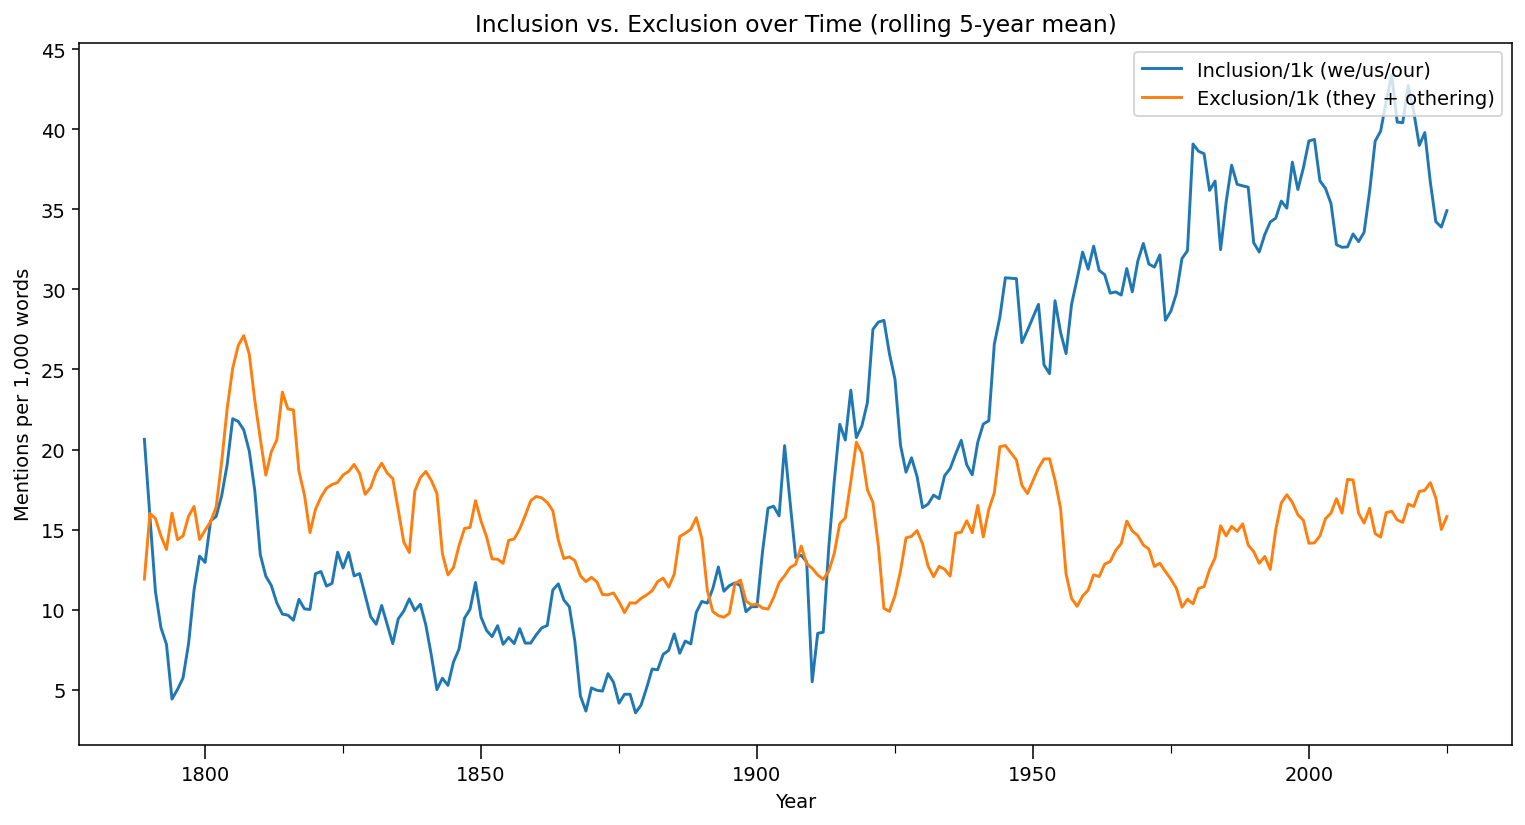

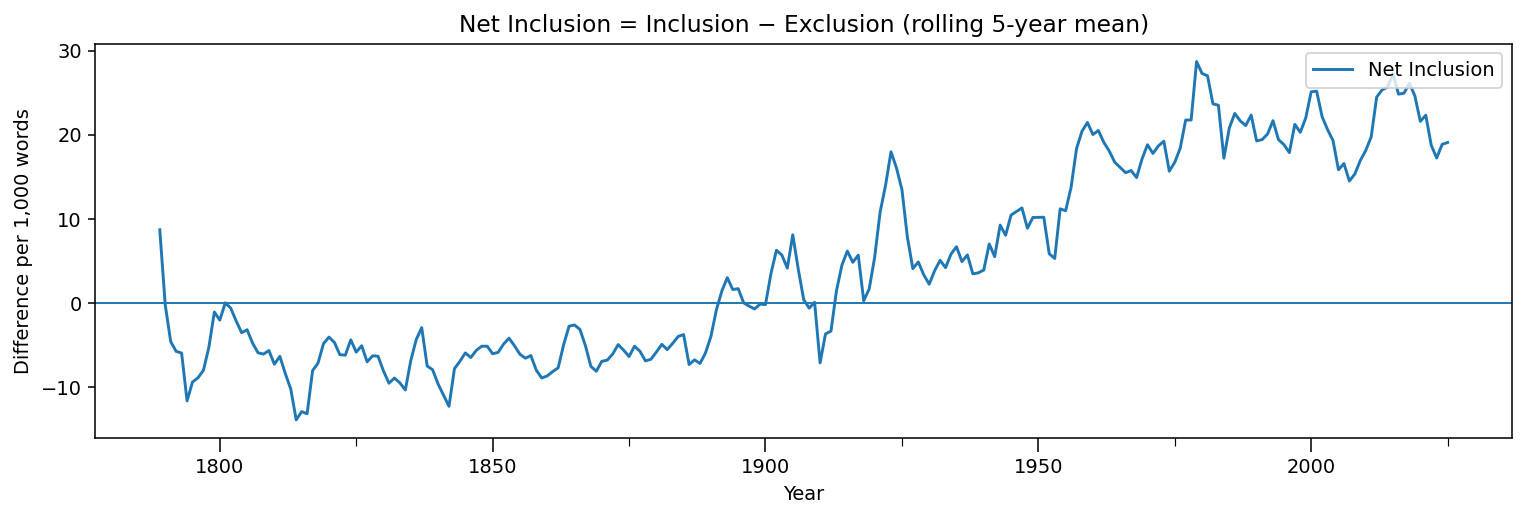

In [49]:
# yearly means and rolling
yearly = speeches.groupby("year")[["inc_per_1k","they_per_1k","others_per_1k"]].mean().sort_index()
roll_n = 5
yr_roll = yearly.rolling(roll_n, min_periods=1).mean()
exc_roll = yr_roll["they_per_1k"] + yr_roll["others_per_1k"]

# A) Inclusion vs Exclusion
fig, ax = plt.subplots(figsize=(11, 6), dpi=140)
ax.plot(yr_roll.index, yr_roll["inc_per_1k"], label="Inclusion/1k (we/us/our)")
ax.plot(yr_roll.index, exc_roll,               label="Exclusion/1k (they + othering)")
ax.set_xlabel("Year"); ax.set_ylabel("Mentions per 1,000 words")
ax.set_title(f"Inclusion vs. Exclusion over Time (rolling {roll_n}-year mean)")
ax.xaxis.set_major_locator(MultipleLocator(50))   # labels every 50 years
ax.xaxis.set_minor_locator(MultipleLocator(25))   # small tick marks every 25
ax.tick_params(axis="x", which="minor", length=4)
ax.tick_params(axis="x", which="major", length=7)
ax.legend(loc="upper right")
plt.tight_layout(); plt.show()

# B) Net Inclusion (Inclusion − Exclusion)
net = yr_roll["inc_per_1k"] - exc_roll
fig, ax = plt.subplots(figsize=(11, 3.8), dpi=140)
ax.plot(net.index, net, label="Net Inclusion")
ax.axhline(0, linewidth=1)
ax.set_xlabel("Year"); ax.set_ylabel("Difference per 1,000 words")
ax.set_title(f"Net Inclusion = Inclusion − Exclusion (rolling {roll_n}-year mean)")
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.xaxis.set_minor_locator(MultipleLocator(25))
ax.tick_params(axis="x", which="minor", length=4)
ax.tick_params(axis="x", which="major", length=7)
ax.legend(loc="upper right")
plt.tight_layout(); plt.show()


In [28]:
import pandas as pd

# --- rebuild or reuse your rolled Inclusion series s (1925–2025) ---
roll_n = ROLL_YEARS if "ROLL_YEARS" in globals() else 5
yearly  = speeches.groupby("year")[["inc_per_1k"]].mean().sort_index()
s = yearly["inc_per_1k"].rolling(roll_n, min_periods=1).mean()
s = s.loc[(s.index >= 1925) & (s.index <= 2025)].dropna()

# --- YoY dips (top 10, most negative) ---
d = s.diff()
dips = (pd.DataFrame({
            "year": d.index,
            "Δ_inclusion": d.values,
            "inclusion": s.values,
            "inclusion_prev": s.shift(1).values
        })
        .dropna()
        .sort_values("Δ_inclusion")
        .head(10))

# --- Drawdowns helper (same as before) ---
def top_drawdowns(series: pd.Series, top_n=5):
    import math
    peak_val = -float("inf"); peak_year = None
    trough_val = None; trough_year = None
    events = []
    for year, val in series.items():
        if pd.isna(val): 
            continue
        if val > peak_val:  # new peak
            peak_val, peak_year = val, year
            trough_val, trough_year = val, year
        else:
            if trough_val is None or val < trough_val:
                trough_val, trough_year = val, year
                abs_drop = trough_val - peak_val
                pct_drop = (trough_val / peak_val - 1) if peak_val else pd.NA
                events.append((peak_year, peak_val, trough_year, trough_val, abs_drop, pct_drop))
    if not events:
        return pd.DataFrame(columns=["peak_year","peak","trough_year","trough","abs_drop","pct_drop"])
    dd = (pd.DataFrame(events, columns=["peak_year","peak","trough_year","trough","abs_drop","pct_drop"])
            .sort_values("abs_drop")
            .drop_duplicates(["trough_year"], keep="first")
            .nsmallest(top_n, "abs_drop"))
    dd[["peak","trough","abs_drop"]] = dd[["peak","trough","abs_drop"]].round(2)
    dd["pct_drop"] = (100 * dd["pct_drop"]).round(1)
    return dd

dd = top_drawdowns(s, top_n=5)

# --- Map year -> dominant president by total words that year ---
# (Use speaker/author if you don't have 'president')
pres_col = "president" if "president" in speeches.columns else (
    "speaker" if "speaker" in speeches.columns else "author"
)

year_top_pres = (speeches[speeches["year"].between(1925, 2025)]
                 .groupby(["year", pres_col])["word_count"].sum()
                 .reset_index()
                 .sort_values(["year","word_count"], ascending=[True, False])
                 .drop_duplicates("year")
                 .rename(columns={pres_col: "top_pres_by_words",
                                  "word_count": "year_words"}))

# --- Annotate the YoY dips with president ---
dips_annot = dips.merge(year_top_pres, on="year", how="left")
dips_annot["Δ_inclusion"] = dips_annot["Δ_inclusion"].round(2)
dips_annot["inclusion"] = dips_annot["inclusion"].round(2)
dips_annot["inclusion_prev"] = dips_annot["inclusion_prev"].round(2)
display(dips_annot)

# --- Annotate drawdowns: add peak & trough presidents ---
peak_map   = year_top_pres.rename(columns={"year":"peak_year",
                                           "top_pres_by_words":"peak_pres",
                                           "year_words":"peak_year_words"})
trough_map = year_top_pres.rename(columns={"year":"trough_year",
                                           "top_pres_by_words":"trough_pres",
                                           "year_words":"trough_year_words"})
dd_annot = (dd.merge(peak_map, on="peak_year", how="left")
              .merge(trough_map, on="trough_year", how="left"))
display(dd_annot[["peak_year","peak","peak_pres","trough_year","trough","trough_pres","abs_drop","pct_drop"]])


,year,Δ_inclusion,inclusion,inclusion_prev,top_pres_by_words,year_words
0,1984,-4.28,32.48,36.76,Ronald Reagan,49328
1,1926,-4.11,20.28,24.39,Calvin Coolidge,14771
2,1974,-4.08,28.07,32.15,Richard M. Nixon,19216
3,1948,-4.00,26.67,30.67,Harry S. Truman,4614
4,1952,-3.77,25.29,29.06,Harry S. Truman,7025
5,1990,-3.47,32.91,36.38,George H. W. Bush,14079
6,2022,-3.09,36.70,39.79,Joe Biden,24600
7,2016,-2.97,40.44,43.41,Barack Obama,15164
8,2002,-2.59,36.77,39.36,George W. Bush,14099
9,2005,-2.57,32.78,35.36,George W. Bush,13813


,peak_year,peak,peak_pres,trough_year,trough,trough_pres,abs_drop,pct_drop
0,2015,43.41,Barack Obama,2024,33.88,Joe Biden,-9.52,-21.9
1,2015,43.41,Barack Obama,2023,34.22,Joe Biden,-9.18,-21.2
2,1925,24.39,Calvin Coolidge,1930,16.37,Herbert Hoover,-8.02,-32.9
3,1979,39.07,Jimmy Carter,1991,32.33,George H. W. Bush,-6.74,-17.3
4,2001,39.36,George W. Bush,2006,32.62,George W. Bush,-6.73,-17.1


### Inclusion dips — what they are and what they say

The **largest year-over-year drops** in Inclusion/1k after 1925 occur in **1984 (Reagan, −4.28), 1926 (Coolidge, −4.11), 1974 (Nixon, −4.08), 1948 & 1952 (Truman, −4.00/−3.77), 1990 (G. H. W. Bush, −3.47), 2022 (Biden, −3.09), 2016 (Obama, −2.97), 2002 & 2005 (G. W. Bush, −2.59/−2.57)**. Each line shows a **one-year step down** in the rate of “we/us/our,” with the rightmost column identifying the **president who dominated the year’s word count** (not necessarily the only speaker). Taken together, these dips cluster around **leadership transitions and high-salience events** (elections, scandals, wars/crises), which is consistent with presidents temporarily **shifting from unifying “we” appeals** toward other rhetorical goals. It doesn’t mean exclusion surged by itself—just that inclusion **fell relative to the prior year**—so the companion exclusion lines/net plot should be checked for each window.

### Multi-year drawdowns — sustained moves away from inclusion

The **worst peak-to-trough slides** show **sustained** lowering in inclusion: **2015→2024 (Obama→Biden: −9.52, −21.9%)**, **1925→1930 (Coolidge→Hoover: −8.02, −32.9%)**, **1979→1991 (Carter→G. H. W. Bush: −6.74, −17.3%)**, and **2001→2006 (G. W. Bush: −6.73, −17.1%)**. These are **multi-year** drawdowns rather than blips, spanning administrations and major contexts. For your question—*when and how do presidents draw inclusion vs. exclusion boundaries?*—the pattern suggests that **inclusive “we/us/our” rhetoric is the baseline**, but it **eases off in extended periods** linked to large agenda or security shifts. Actionably, those windows are prime for: (1) checking whether **exclusion/othering rises** in parallel, and (2) pulling **KWIC quotes** to show how framing changed on the ground.


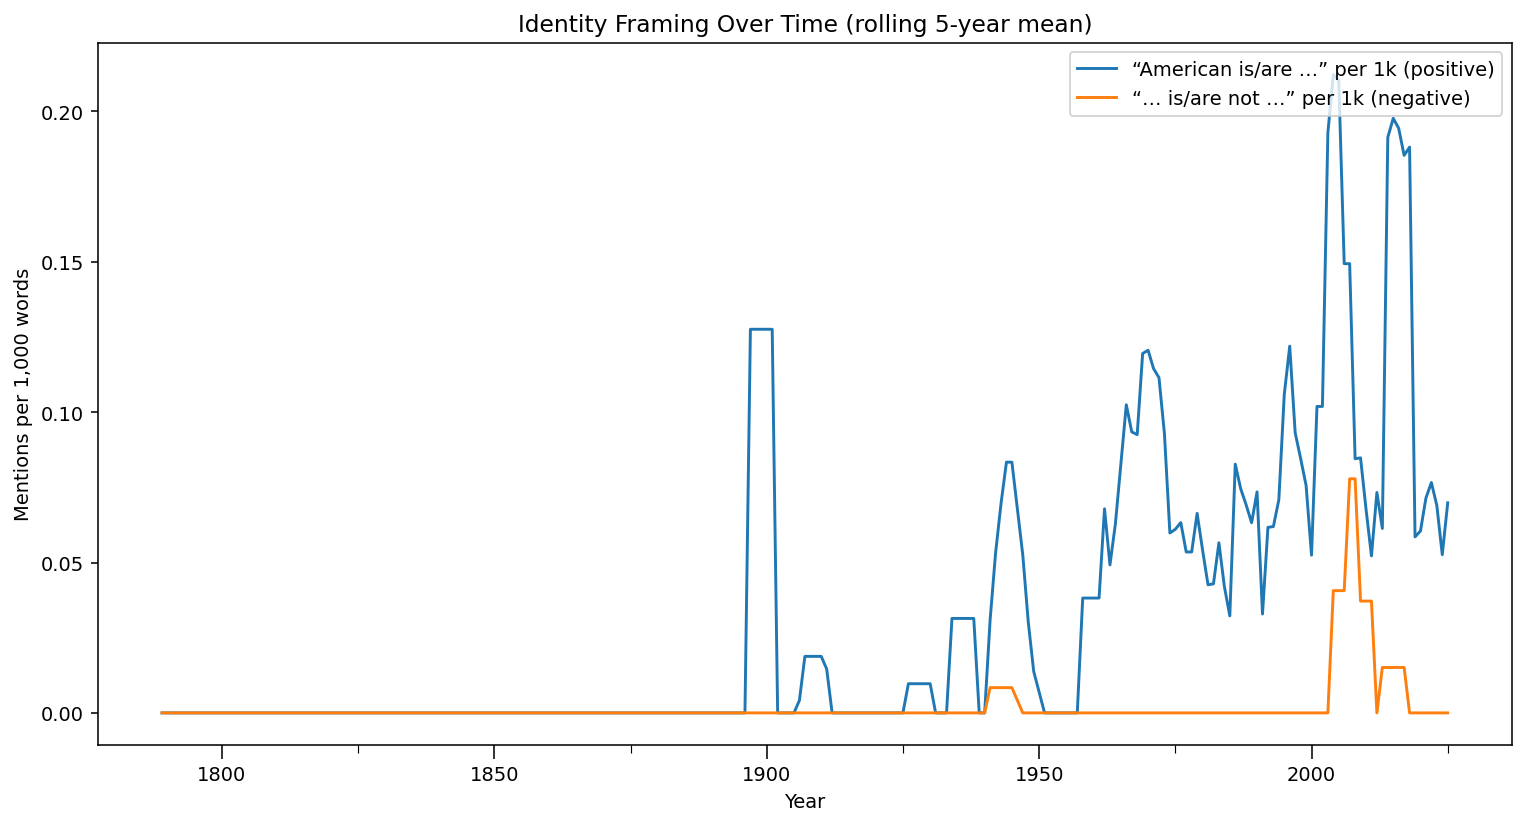

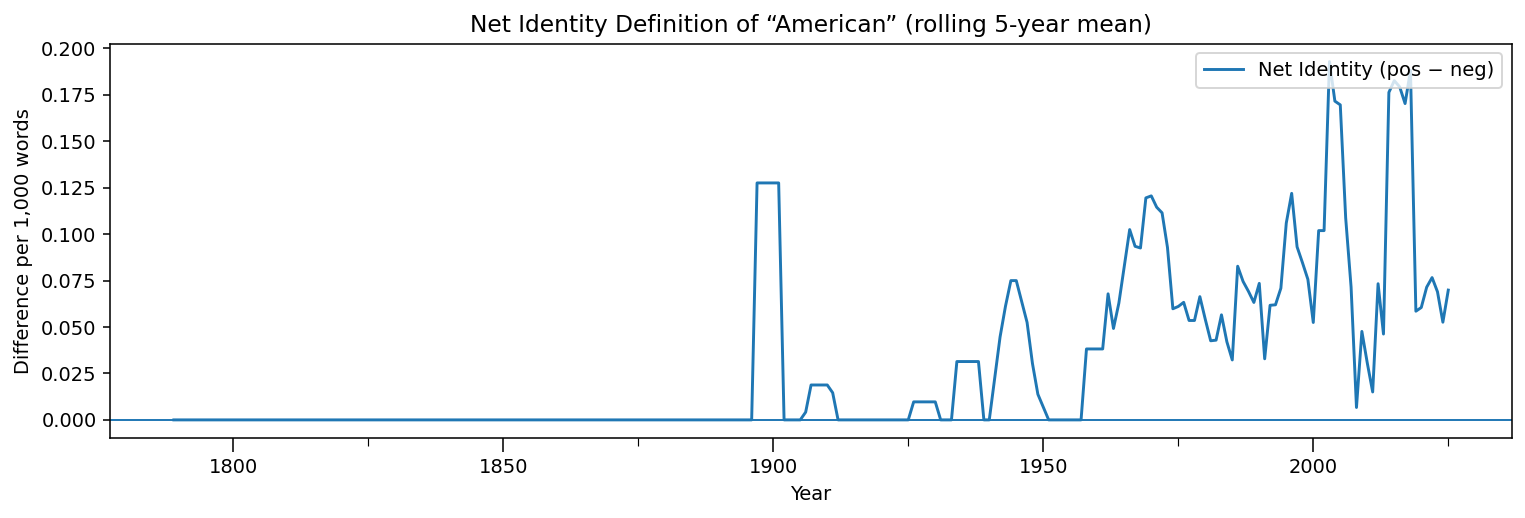

In [31]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

roll_n = 5  # rolling window in years

# yearly means and rolling smoothing
yr_id = (speeches.groupby("year")[["amer_is_pos_per_1k","amer_is_not_per_1k","amer_identity_net"]]
                  .mean()
                  .sort_index())
yr_id_roll = yr_id.rolling(roll_n, min_periods=1).mean()

# A) Positive vs Negative identity lines
fig, ax = plt.subplots(figsize=(11, 6), dpi=140)
ax.plot(yr_id_roll.index, yr_id_roll["amer_is_pos_per_1k"], label='“American is/are …” per 1k (positive)')
ax.plot(yr_id_roll.index, yr_id_roll["amer_is_not_per_1k"], label='“… is/are not …” per 1k (negative)')
ax.set_title(f'Identity Framing Over Time (rolling {roll_n}-year mean)')
ax.set_xlabel("Year"); ax.set_ylabel("Mentions per 1,000 words")
ax.xaxis.set_major_locator(MultipleLocator(50))   # labels every 50
ax.xaxis.set_minor_locator(MultipleLocator(25))   # marks every 25
ax.tick_params(axis="x", which="minor", length=4)
ax.tick_params(axis="x", which="major", length=7)
ax.legend(loc="upper right")
plt.tight_layout(); plt.show()

# B) Net identity (pos − neg)
fig, ax = plt.subplots(figsize=(11, 3.8), dpi=140)
ax.plot(yr_id_roll.index, yr_id_roll["amer_identity_net"], label="Net Identity (pos − neg)")
ax.axhline(0, linewidth=1)
ax.set_title(f'Net Identity Definition of “American” (rolling {roll_n}-year mean)')
ax.set_xlabel("Year"); ax.set_ylabel("Difference per 1,000 words")
ax.xaxis.set_major_locator(MultipleLocator(50))
ax.xaxis.set_minor_locator(MultipleLocator(25))
ax.tick_params(axis="x", which="minor", length=4)
ax.tick_params(axis="x", which="major", length=7)
ax.legend(loc="upper right")
plt.tight_layout(); plt.show()


**What we’re doing & why it matters:**
These charts isolate **explicit identity statements**—lines where presidents literally define who we are (e.g., **“An American/Americans is/are …”**) versus define by negation (**“… is/are not …”**). We compute rates per 1,000 words and smooth with a **5-year window** so single speeches don’t dominate. answers the question’s second part: not just inclusive/exclusive *pronoun framing*, but **when and how presidents explicitly say what “an American” is (or is not)**.

**What the results show (plain English):**
Explicit definitions are **rare**, but when they appear they’re **mostly positive**. The blue line (positive “is/are …”) shows intermittent spikes—especially in the late 20th and early 21st centuries—while the orange line (negative “is/are not …”) hugs **near zero** with brief bumps in the 2000s. The **net identity** plot stays **above zero** for most modern periods, meaning presidents who explicitly define “American” tend to do it **affirmatively** rather than by exclusion. Taken with your pronoun charts, the picture is: presidents usually draw a **wide circle** using “we/us/our,” and on the occasions they explicitly define “American,” they **reinforce** that inclusive stance rather than policing identity with “is not” statements.


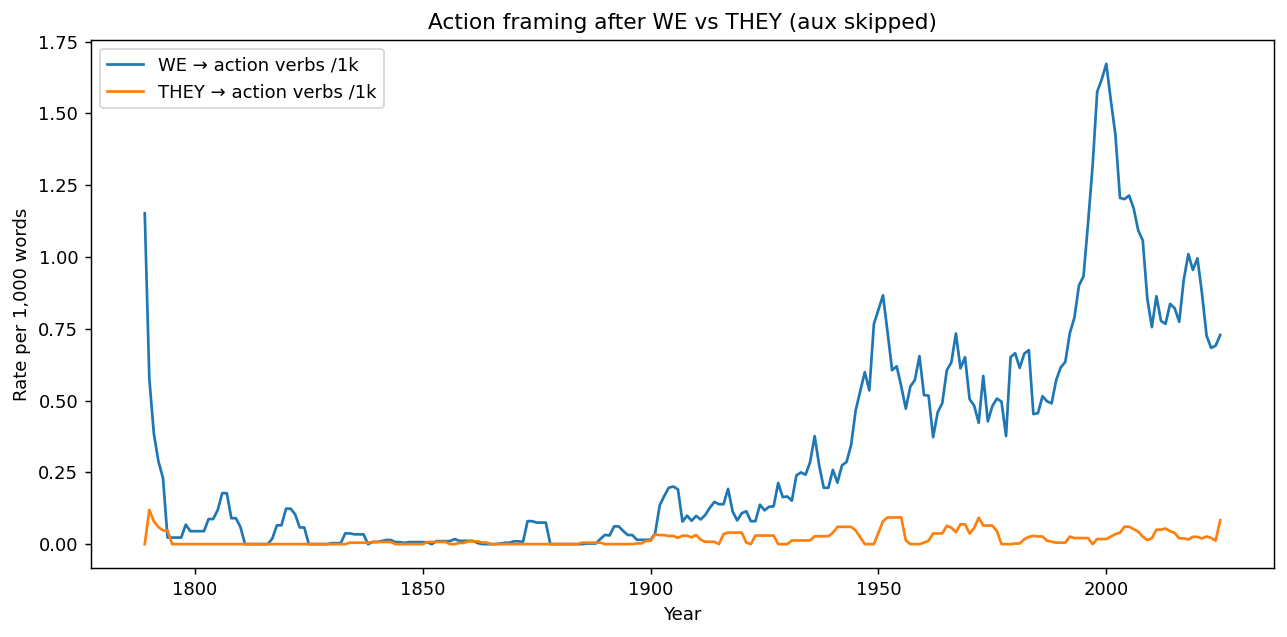

In [36]:
WE_VERBS   = {"build","create","unite","protect","defend","lead","work","help","support","secure","invest","expand"}
THEY_VERBS = {"threaten","attack","undermine","oppose","violate","terrorize","invade","harm","divide","challenge","kill"}

# Tokens to skip after the pronoun (auxiliaries, negators, filler)
AUX_SKIP = {
    "will","shall","would","should","can","could","may","might","must",
    "do","does","did","is","are","am","was","were","be","been","being",
    "have","has","had","to","not","n't","also","just","still","then","now","already","here","there"
}

WE_SET   = {"we","us","our","ours","ourselves"}
THEY_SET = {"they","them","their","theirs","themselves"}

word_re = re.compile(r"[A-Za-z']+")

def normalize(w: str) -> str:
    w = w.lower().strip("'")
    # very light lemmatization for common English verb endings
    for suf in ("ing","ed","es","s"):
        if w.endswith(suf) and len(w) > len(suf) + 2:
            w = w[: -len(suf)]
            break
    return w

def next_content_words(text: str, pron_set, window: int = 8):
    """Return the first non-aux content word within `window` tokens after each pronoun occurrence."""
    if not text:
        return []
    toks = [t.lower() for t in word_re.findall(text)]
    hits = []
    for i, t in enumerate(toks):
        if t in pron_set:
            for j in range(i + 1, min(i + 1 + window, len(toks))):
                cand = toks[j]
                if cand in AUX_SKIP:
                    continue
                hits.append(normalize(cand))
                break
    return hits

def count_actions(series, pron_set, verbset, window: int = 8):
    return series.fillna("").map(lambda s: sum(1 for w in next_content_words(s, pron_set, window) if w in verbset))

# --- counts (skip auxiliaries) ---
speeches["we_action_ct"]   = count_actions(speeches[TEXT_COL], WE_SET,   WE_VERBS)
speeches["they_action_ct"] = count_actions(speeches[TEXT_COL], THEY_SET, THEY_VERBS)

# per-1k
for c in ["we_action_ct","they_action_ct"]:
    speeches[c.replace("_ct","_per_1k")] = 1000 * speeches[c] / speeches["word_count"]

# roll + plot
year_act = (speeches.groupby("year")[["we_action_per_1k","they_action_per_1k"]]
                     .mean()
                     .rolling(5, min_periods=1).mean())

fig, ax = plt.subplots(figsize=(10,5), dpi=130)
ax.plot(year_act.index, year_act["we_action_per_1k"],   label="WE → action verbs /1k")
ax.plot(year_act.index, year_act["they_action_per_1k"], label="THEY → action verbs /1k")
ax.set_xlabel("Year"); ax.set_ylabel("Rate per 1,000 words"); ax.set_title("Action framing after WE vs THEY (aux skipped)")
ax.legend(); plt.tight_layout(); plt.show()



Presidents overwhelmingly frame “us” as the doers—builders, protectors, leaders—while “they” are only occasionally cast as threatening actors. So the boundary isn’t drawn mainly by constant villainizing of an out-group; it’s drawn by mobilizing the in-group and using “they” action language situationally when threat is salient. This pairs with your earlier results (inclusion > exclusion; explicit identity mostly positive): the default presidential stance is inclusive and agentic—“we” act to secure and improve—while references to “they” acting against us are episodic, not the baseline.

In [35]:
ADJ = {"free","strong","equal","proud","hardworking","compassionate","brave","diverse","united","creative","optimistic","resilient"}

def adj_after_americans(text):
    if not text: return 0
    rx = re.compile(r"\b(american|americans)\b\s+([A-Za-z']+)", re.I)
    return sum(1 for m in rx.finditer(text) if m.group(2).lower() in ADJ)

speeches["amer_adj_ct"] = speeches[TEXT_COL].map(adj_after_americans)
speeches["amer_adj_per_1k"] = 1000*speeches["amer_adj_ct"]/speeches["word_count"]

year_adj = speeches.groupby("year")["amer_adj_per_1k"].mean().rolling(5, min_periods=1).mean()

# Top adjectives (corpus totals)
import collections, re
ctr = collections.Counter()
for s in speeches[TEXT_COL].fillna(""):
    for m in re.finditer(r"\b(american|americans)\b\s+([A-Za-z']+)", s, flags=re.I):
        ctr[m.group(2).lower()] += 1
print("Top adjectives after American(s):", ctr.most_common(20))


Top adjectives after American(s): [('people', 1459), ('citizens', 252), ('who', 235), ('have', 181), ('and', 157), ('to', 148), ('are', 148), ('citizen', 85), ('in', 81), ('system', 81), ('workers', 78), ('republics', 77), ('states', 74), ('jobs', 74), ('will', 71), ('life', 69), ('flag', 65), ('troops', 63), ('history', 63), ('families', 62)]


In [32]:
# Year table (last ~12 rows)
yr_tbl = as_display(yr, ["inc_per_1k","they_per_1k","others_per_1k","inc_exc_ratio"], index_name="Year")
display(yr_tbl.tail(12))

# President table (if available)
if PRES_COL:
    pres_tbl_raw = (speeches.groupby(PRES_COL)[
        ["inc_per_1k","they_per_1k","others_per_1k","inc_exc_ratio",
         "amer_is_pos_per_1k","amer_is_not_per_1k","amer_identity_net"]
    ].mean().sort_values("inc_exc_ratio", ascending=False))
    pres_tbl = as_display(pres_tbl_raw, pres_tbl_raw.columns.tolist(), index_name="President")
    display(pres_tbl.head(15))

,Inclusion/1k,They/1k,Othering/1k,Incl:Excl
Year,,,,
2014,42.138,14.514,5.603,2.284
2015,42.902,10.997,2.567,3.199
2016,34.947,9.805,2.705,2.742
2017,47.909,11.329,3.976,3.219
2018,45.746,18.178,3.296,2.230
2019,33.877,14.735,4.628,1.975
2020,32.439,15.049,3.186,2.199
2021,38.956,10.237,2.632,3.641
2022,32.481,13.635,4.070,2.071


,Inclusion/1k,They/1k,Othering/1k,Incl:Excl,“American is/are …” /1k,“… is/are not …” /1k,Net identity (pos−neg)
President,,,,,,,
Warren G. Harding,34.278,8.752,1.617,6.024,0.000,0.000,0.000
Jimmy Carter,37.369,7.194,3.586,4.332,0.045,0.000,0.045
Joe Biden,33.385,11.442,2.851,3.186,0.075,0.000,0.075
George H. W. Bush,32.343,9.491,2.091,3.117,0.069,0.000,0.069
Gerald Ford,29.286,7.011,2.692,3.093,0.076,0.000,0.076
Barack Obama,39.373,11.691,2.542,2.951,0.079,0.015,0.064
Dwight D. Eisenhower,30.006,7.192,3.470,2.900,0.013,0.000,0.013
Bill Clinton,37.655,12.599,3.314,2.847,0.075,0.000,0.075
Ronald Reagan,34.626,12.473,3.166,2.734,0.053,0.000,0.053
